# CNN Model for detection of Melanoma
___

### Problem statement: 
 
To build a CNN based model which can accurately detect melanoma.



__Melanoma__: is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Imports

#### Import Libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

from glob import glob
import cv2

#### Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Read Data

In [3]:
main_location = "/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration"

In [4]:
train_data_path = pathlib.Path(main_location + "/Train")
test_data_path = pathlib.Path(main_location + "/Test")

In [5]:
image_count_train = len(list(train_data_path.glob('*/*.jpg')))
print("Total Number of Images in Train :",image_count_train)
image_count_test = len(list(test_data_path.glob('*/*.jpg')))
print("Total Number of Images in Test :", image_count_test)

Total Number of Images in Train : 2239
Total Number of Images in Test : 118


In [6]:
print(os.listdir(train_data_path))

['.DS_Store', 'melanoma', 'pigmented benign keratosis', 'squamous cell carcinoma', 'basal cell carcinoma', 'actinic keratosis', 'dermatofibroma', 'nevus', 'vascular lesion', 'seborrheic keratosis']


___

### Data Preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

#### Define Parameters

In [7]:
batch_size = 32
img_height = 180
img_width = 180

#### Create Train and Validation set using Training Data
- 80% of the images for training, and 20% for validation

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_data_path,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [10]:
class_names = train_ds.class_names
print(class_names)

class_names = val_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#### Visualization

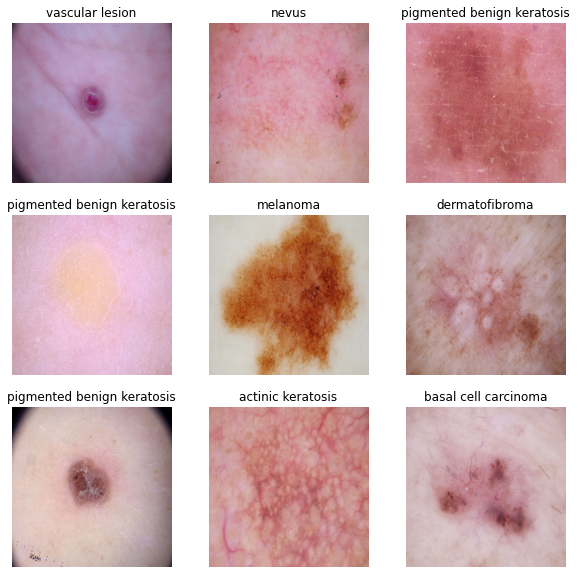

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


#### Keep images in memory after they're loaded off disk during the first epoch

In [15]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Normalization later

In [16]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

___
## Base Model

In [17]:
num_classes = 9

model = tf.keras.Sequential([
  #tf.keras.layers.InputLayer(input_shape=(180,180,3)),
  tf.keras.layers.Rescaling(1./255, input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(128, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])


In [18]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 45, 45, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 128)       7

In [21]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 269s 1s/step - loss: 1.9981 - accuracy: 0.2779 - val_loss: 1.9381 - val_accuracy: 0.2908
Epoch 2/20
56/56 [==============================] - 2s 42ms/step - loss: 1.7497 - accuracy: 0.3733 - val_loss: 1.7527 - val_accuracy: 0.3423
Epoch 3/20
56/56 [==============================] - 2s 42ms/step - loss: 1.5391 - accuracy: 0.4381 - val_loss: 1.4707 - val_accuracy: 0.4787
Epoch 4/20
56/56 [==============================] - 2s 43ms/step - loss: 1.4361 - accuracy: 0.4972 - val_loss: 1.4028 - val_accuracy: 0.5190
Epoch 5/20
56/56 [==============================] - 2s 42ms/step - loss: 1.3185 - accuracy: 0.5352 - val_loss: 1.3496 - val_accuracy: 0.5078
Epoch 6/20
56/56 [==============================] - 2s 42ms/step - loss: 1.2226 - accuracy: 0.5759 - val_loss: 1.3489 - val_accuracy: 0.5436
Epoch 7/20
56/56 [==============================] - 2s 43ms/step - loss: 1.1065 - accuracy: 0.6038 - val_loss: 1.5707 - val_accuracy: 0.5324
Epoch 8/20
56

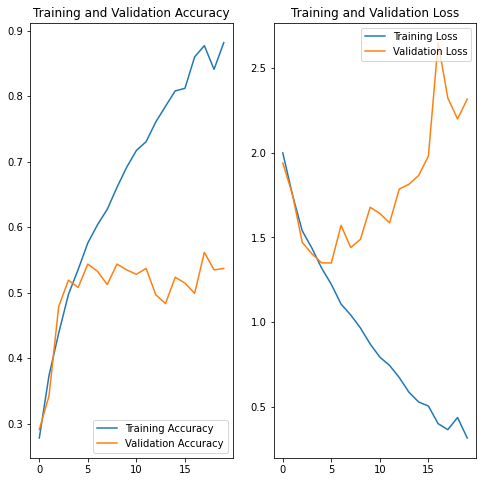

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observation: 
##### Model is definitly overfitting. 
##### Training accuracy after 5/6 epoches has jumped , but validation accuracies did not. This clearly indicates that model is overfitting as there are less number of samples. 

___

### In order to get rid of overfitting:
- We can add layer of data augmentation
- We can use dropouts

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Visualization of Augmentated Images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


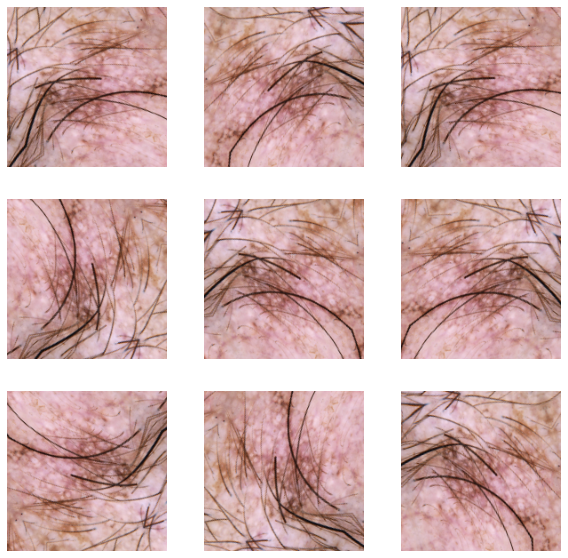

In [24]:
plt.figure(figsize = (10,10))
for images, _ in train_ds.take(5):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3,3,i+1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

___
## Model 2 - With Drop-outs and augmentation layers

In [25]:
num_classes = 9

model1 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(180,180,3)),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.Rescaling(1./255),#, input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  #tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128, 3, padding = 'same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [26]:
model1.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [27]:
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 180, 180, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 180, 180, 3)      0         
 tation)                                                         
                                                                 
 rescaling_2 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 90, 90, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 90, 90, 64)       

In [28]:
epochs = 20
history = model1.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 5s 70ms/step - loss: 2.3367 - accuracy: 0.1836 - val_loss: 2.0529 - val_accuracy: 0.1544
Epoch 2/20
56/56 [==============================] - 4s 67ms/step - loss: 2.0084 - accuracy: 0.2249 - val_loss: 1.9337 - val_accuracy: 0.2327
Epoch 3/20
56/56 [==============================] - 4s 67ms/step - loss: 1.9207 - accuracy: 0.2941 - val_loss: 2.1171 - val_accuracy: 0.2192
Epoch 4/20
56/56 [==============================] - 4s 65ms/step - loss: 1.9239 - accuracy: 0.3119 - val_loss: 1.7814 - val_accuracy: 0.4251
Epoch 5/20
56/56 [==============================] - 4s 66ms/step - loss: 1.7082 - accuracy: 0.4007 - val_loss: 1.5727 - val_accuracy: 0.4430
Epoch 6/20
56/56 [==============================] - 4s 66ms/step - loss: 1.5672 - accuracy: 0.4459 - val_loss: 1.4439 - val_accuracy: 0.5168
Epoch 7/20
56/56 [==============================] - 4s 66ms/step - loss: 1.4584 - accuracy: 0.4961 - val_loss: 1.4230 - val_accuracy: 0.5034
Epoch 8/20
56

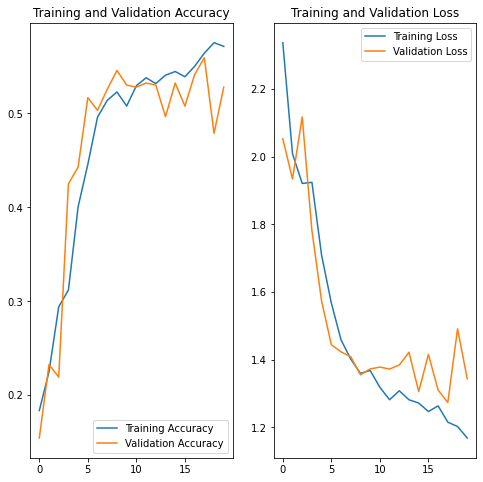

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Observations:

##### The Model with Augmentation and Dropouts underfits

##### One possible reason could be sample size distribution among the classes in training data

In [31]:
df_eda = pd.DataFrame()

classes = []
train_image_number_breakdown = {}
test_image_number_breakdown = {}
number_test_images = 0
number_train_images = 0
for class_name in os.listdir(train_data_path):
    classes.append(class_name)
    path = os.path.join(train_data_path,class_name)
    count = len([entry for entry in os.listdir(path) if os.path.isfile(os.path.join(path, entry))]) 
    train_image_number_breakdown[class_name] = count
    number_train_images += count


for class_name in os.listdir(test_data_path):
    classes.append(class_name)
    path = os.path.join(test_data_path,class_name)
    count = len([entry for entry in os.listdir(path) if os.path.isfile(os.path.join(path, entry))]) 
    test_image_number_breakdown[class_name] = count
    number_test_images += count

classes = list(set(classes))

In [32]:
print("Number of Train Images {}".format(number_train_images))
print("Number of Test Images {}".format(number_test_images))
print("**"*25)
print("Train Images Breakdown {}".format(train_image_number_breakdown))
print("__"*25)
print("Test Images Breakdown {}".format(test_image_number_breakdown))
print("__"*25)
print("Classes {}".format(classes))

Number of Train Images 2239
Number of Test Images 118
**************************************************
Train Images Breakdown {'melanoma': 438, 'pigmented benign keratosis': 462, 'squamous cell carcinoma': 181, 'basal cell carcinoma': 376, 'actinic keratosis': 114, 'dermatofibroma': 95, 'nevus': 357, 'vascular lesion': 139, 'seborrheic keratosis': 77}
__________________________________________________
Test Images Breakdown {'squamous cell carcinoma': 16, 'pigmented benign keratosis': 16, 'seborrheic keratosis': 3, 'basal cell carcinoma': 16, 'actinic keratosis': 16, 'dermatofibroma': 16, 'melanoma': 16, 'nevus': 16, 'vascular lesion': 3}
__________________________________________________
Classes ['dermatofibroma', 'basal cell carcinoma', 'squamous cell carcinoma', 'pigmented benign keratosis', 'actinic keratosis', 'nevus', 'melanoma', 'vascular lesion', 'seborrheic keratosis']


In [33]:
train_image_number_breakdown

{'melanoma': 438,
 'pigmented benign keratosis': 462,
 'squamous cell carcinoma': 181,
 'basal cell carcinoma': 376,
 'actinic keratosis': 114,
 'dermatofibroma': 95,
 'nevus': 357,
 'vascular lesion': 139,
 'seborrheic keratosis': 77}

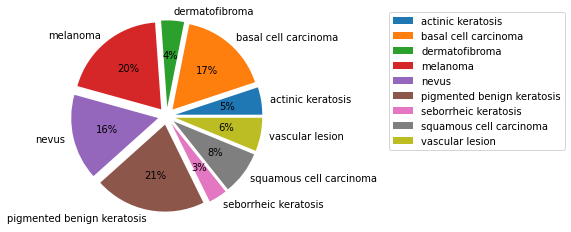

In [34]:
dict1 = pd.DataFrame(train_image_number_breakdown.items(), columns = ['Class','Count'])
#dict1.plot(y='Count', x='Class')
explode = [0.1]*9
dict1.groupby(['Class']).sum().plot(kind='pie', y='Count', autopct='%1.0f%%', explode=explode, ylabel = '')
plt.legend(bbox_to_anchor=(1.5,1))
plt.show()

##### There's considerable class imbalance that needs to be handeled
##### Hence we would need to create/augment data

___

### Augmentation with rotation

In [35]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [36]:
path_to_training_dataset= "/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(750)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6FDB8FAE90>: 100%|██████████| 750/750 [00:31<00:00, 23.92 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6FF2062490>: 100%|██████████| 750/750 [00:32<00:00, 23.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F6FDB8E9F10>: 100%|██████████| 750/750 [00:27<00:00, 27.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F6FD8148DD0>: 100%|██████████| 750/750 [02:23<00:00,  5.24 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F6FF2066DD0>: 100%|██████████| 750/750 [01:58<00:00,  6.33 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6FDB98E110>: 100%|██████████| 750/750 [00:27<00:00, 27.50 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F6FDBC08A90>: 100%|██████████| 750/750 [01:00<00:00, 12.46 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6FDBF298D0>: 100%|██████████| 750/750 [00:26<00:00, 27.85 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F6FDC6CBA50>: 100%|██████████| 750/750 [00:29<00:00, 25.86 Samples/s]


In [37]:
image_count_train = len(list(train_data_path.glob('*/output/*.jpg')))
print(image_count_train)

6750


In [38]:
path_list_new = [x for x in glob(os.path.join(train_data_path, '*','output', '*.jpg'))]
path_list_new[:5]

['/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009950.jpg_c1694c48-d17b-49e9-93c2-b3a50214e3c7.jpg',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011012.jpg_e982e639-8c02-49fb-bdaa-79674047e980.jpg',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010322.jpg_e4fad9a1-16f7-453a-9829-2aa12f84af53.jpg',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011121.jpg_8d22f3a5-f868-48ce-bd62-3d0dafa90017.jpg',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000307.jpg_62e9f7a0-587d-47b2-b0f9-2cf5f3c9feda.jpg']

In [39]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(train_data_path, '*','output', '*.jpg'))]
lesion_list_new[:5]

['melanoma', 'melanoma', 'melanoma', 'melanoma', 'melanoma']

In [40]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))
dataframe_dict_new

{'/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0009950.jpg_c1694c48-d17b-49e9-93c2-b3a50214e3c7.jpg': 'melanoma',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011012.jpg_e982e639-8c02-49fb-bdaa-79674047e980.jpg': 'melanoma',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0010322.jpg_e4fad9a1-16f7-453a-9829-2aa12f84af53.jpg': 'melanoma',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0011121.jpg_8d22f3a5-f868-48ce-bd62-3d0dafa90017.jpg': 'melanoma',
 '/content/gdrive/My Drive/app/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output/melanoma_original_ISIC_0000307.jpg_62e9f7a0-587d-47b2-b0f9-2cf5f3

In [41]:
train_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [42]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = train_ds.append(df2)

#### Augmentated Data output counts

In [43]:
df2['Label'].value_counts()

melanoma                      750
pigmented benign keratosis    750
squamous cell carcinoma       750
basal cell carcinoma          750
actinic keratosis             750
dermatofibroma                750
nevus                         750
vascular lesion               750
seborrheic keratosis          750
Name: Label, dtype: int64

___
## Model 3 - With Dropouts; With pre-augmentated data (to balance to classes)

In [44]:
batch_size = 32
img_height = 180
img_width = 180

In [45]:
data_dir_train= train_data_path
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'training',## Todo choose the correct parameter value, so that only training data is refered to,,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 8989 files belonging to 9 classes.
Using 7192 files for training.


In [46]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
                                  data_dir_train,
                                  seed=123,
                                  validation_split = 0.2,
                                  subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
                                  image_size=(img_height, img_width),
                                  batch_size=batch_size)

Found 8989 files belonging to 9 classes.
Using 1797 files for validation.


In [47]:
num_classes = 9

model2 = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(180,180,3)),
  #layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  #layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.Rescaling(1./255),#, input_shape=(180,180,3)),
  tf.keras.layers.Conv2D(32, 3, padding = 'same', activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(64, 3, padding = 'same', activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Conv2D(128, 3, padding = 'same', activation='relu'),
  #tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [48]:
model2.compile(optimizer = 'adam', 
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [49]:
epochs = 30
history = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
225/225 [==============================] - 42s 179ms/step - loss: 2.0955 - accuracy: 0.2065 - val_loss: 1.7572 - val_accuracy: 0.3372
Epoch 2/30
225/225 [==============================] - 40s 175ms/step - loss: 1.5288 - accuracy: 0.4152 - val_loss: 1.3483 - val_accuracy: 0.4953
Epoch 3/30
225/225 [==============================] - 42s 181ms/step - loss: 1.2928 - accuracy: 0.5118 - val_loss: 1.4487 - val_accuracy: 0.4741
Epoch 4/30
225/225 [==============================] - 45s 196ms/step - loss: 1.1316 - accuracy: 0.5774 - val_loss: 1.0793 - val_accuracy: 0.6238
Epoch 5/30
225/225 [==============================] - 41s 177ms/step - loss: 1.0375 - accuracy: 0.6164 - val_loss: 1.0037 - val_accuracy: 0.6589
Epoch 6/30
225/225 [==============================] - 40s 174ms/step - loss: 0.8609 - accuracy: 0.6897 - val_loss: 0.8422 - val_accuracy: 0.6912
Epoch 7/30
225/225 [==============================] - 41s 177ms/step - loss: 0.7553 - accuracy: 0.7259 - val_loss: 0.8120 - val_ac

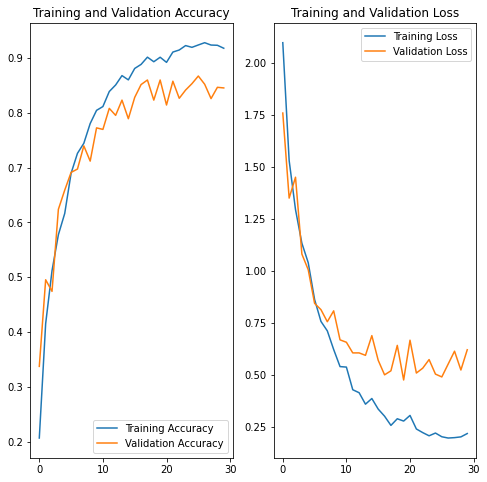

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

___
## Conclusion:
### Final Model has a accuracy of 92% on training data, and 85% on validation data.
#### The model is neigther overfitting nor underfitting now. Balancing helped resolve the over and underfitting 
#### The model looks stable throught the epoches and balanced